###  Created by Luis A. Sanchez-Perez (alejand@umich.edu)

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as alg
import matplotlib.pyplot as plt
from scipy.stats import laplace
from scipy.stats import norm
from scipy.stats import t
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [2]:
# Data generation
m = 100
data = rnd.normal(size=(m,1))
n = 20
outliers = rnd.normal(loc=7,scale=2,size=(n,1))

In [3]:
# Plot distributions
def plot_distributions(y):
    mesh = np.linspace(-5,10,100) 
    plt.hist(y, density=True, histtype='stepfilled', alpha=0.2)
    median, decay = laplace.fit(y)
#     median = np.median(y)
#     decay = (np.abs(y - median)).mean()
    plt.plot(mesh,laplace.pdf(mesh,median,decay),label='laplace')
    avg, std = norm.fit(y)
    plt.plot(mesh,norm.pdf(mesh,avg,std),label='normal')
    degree, mean, scale = t.fit(y)
    plt.plot(mesh,t.pdf(mesh,degree,mean,scale),label='student T')

Text(0.5, 1.0, 'With Outliers')

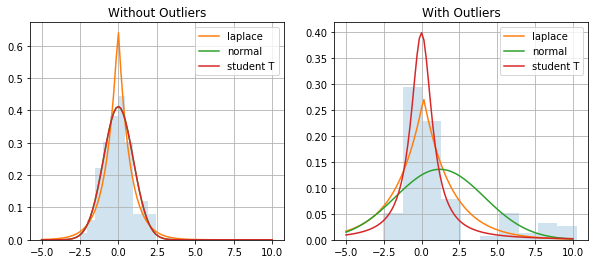

In [4]:
# Data without outliers
y = data
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_distributions(y)
plt.legend()
plt.grid()
plt.title('Without Outliers')
# Data with outliers
plt.subplot(122)
y = np.vstack((data,outliers))
plot_distributions(y)
plt.legend()
plt.grid()
plt.title('With Outliers')

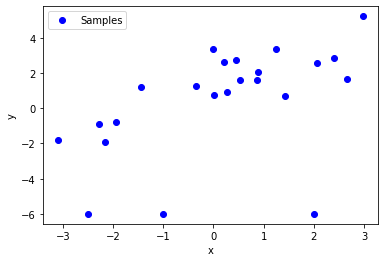

In [5]:
# Generates data from linear model with outliers
np.random.seed(10)
m = 20
wreal = np.array([1, 1])
x = rnd.normal(0,2,(m,1))
outliers = np.array([[-2.5, -6],[-1,-6], [2,-6]])
x = np.vstack((x,outliers[:,0].reshape(3,1)))
poly = PolynomialFeatures(1)
X = poly.fit_transform(x)
sigma = 1
err = rnd.normal(0,sigma,m)
y = X[:-3,:].dot(wreal) + err
y = np.concatenate((y,outliers[:,1]))
plt.plot(X[:,1],y,'bo', markersize = 6, label='Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [6]:
# Preprocessing
degree = 1
poly = PolynomialFeatures(degree)
X = poly.fit_transform(x)
scaler = StandardScaler()
X[:,1:] = scaler.fit_transform(X[:,1:])

In [7]:
pts = 200
x = np.linspace(min(x),max(x),pts).reshape(pts,1)
poly = PolynomialFeatures(degree)

### Using normal distribution to explain y

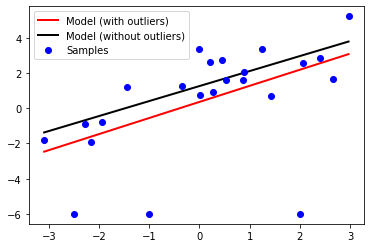

In [8]:
mesh = poly.fit_transform(x)
mesh[:,1:] = scaler.transform(mesh[:,1:])
# With outliers
wmle = alg.pinv(X).dot(y)
h = mesh.dot(wmle)
temp = scaler.inverse_transform(mesh[:,1:])
plt.plot(temp[:,0],h,'r-', linewidth = 2, label = 'Model (with outliers)')
# Without outliers
wmle = alg.pinv(X[:-3,:]).dot(y[:-3])
h = mesh.dot(wmle)
temp = scaler.inverse_transform(mesh[:,1:])
plt.plot(temp[:,0],h,'k-', linewidth = 2, label = 'Model (without outliers)')
temp = scaler.inverse_transform(X[:,1:])
plt.plot(temp[:,0],y,'bo', markersize = 6, label = 'Samples')
plt.legend()

### Using laplace distribution to explain y

In [9]:
def laplace_cost(w,X,y):
    return np.abs(X.dot(w) - y).sum()

In [10]:
w0 = 1e-4 * np.random.rand(X.shape[1])
op = {'fatol': 1e-8}
pts = 200
x = np.linspace(min(x),max(x),pts).reshape(pts,1)
poly = PolynomialFeatures(degree)

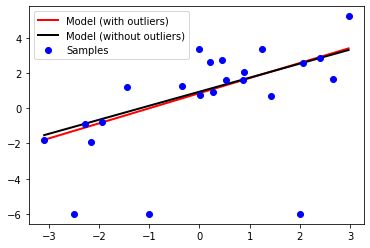

In [11]:
mesh = poly.fit_transform(x)
mesh[:,1:] = scaler.transform(mesh[:,1:])
# With outliers
result = opt.minimize(laplace_cost, w0, method = 'Nelder-Mead', args = (X,y), options = op)
w = result.x
h = mesh.dot(w)
temp = scaler.inverse_transform(mesh[:,1:])
plt.plot(temp[:,0],h,'r-', linewidth = 2, label = 'Model (with outliers)')
# Without outliers
result = opt.minimize(laplace_cost, w0, method = 'Nelder-Mead', args = (X[:-3,:],y[:-3]), options = op)
w = result.x
h = mesh.dot(w)
temp = scaler.inverse_transform(mesh[:,1:])
plt.plot(temp[:,0],h,'k-', linewidth = 2, label = 'Model (without outliers)')
temp = scaler.inverse_transform(X[:,1:])
plt.plot(temp[:,0],y,'bo', markersize = 6, label = 'Samples')
plt.legend()

### Using huber loss

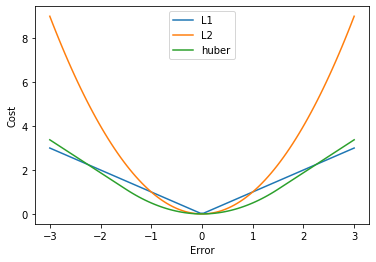

In [12]:
pts = 100
err = np.linspace(-3,3,pts)
L1 = np.abs(err)
L2 = err**2
delta = 1.5
i = np.abs(err) <= delta
huber = 0.5*i*(L2) + (1-i)*(delta*(L1 - delta/2))
plt.plot(err,L1,label='L1')
plt.plot(err,L2,label='L2')
plt.plot(err,huber,label='huber')
plt.xlabel('Error')
plt.ylabel('Cost')
plt.legend()

In [13]:
def huber_cost(w,X,y,delta=0.5):
    err = X.dot(w) - y
    k = np.abs(err) <= delta
    huber = 0.5*k*(err**2) + (1-k)*(delta*(np.abs(err) - delta/2))
    return huber.sum()

def huber_cost_grad(w,X,y,delta=0.5):
    err = (X.dot(w) - y).reshape(len(y),1)
    k = (np.abs(err) <= delta).flatten()
    grad = (X[k,:].T).dot(err[k,:]) + delta*(X[~k,:].T).dot(np.sign(err[~k,:]))
    return grad

In [14]:
w0 = 1e-4 * np.random.rand(X.shape[1])
op = {'gtol': 1e-8}
pts = 200
x = np.linspace(min(x),max(x),pts).reshape(pts,1)
poly = PolynomialFeatures(degree)

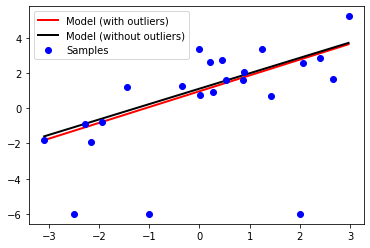

In [15]:
mesh = poly.fit_transform(x)
mesh[:,1:] = scaler.transform(mesh[:,1:])
# With outliers
result = opt.minimize(huber_cost, w0, method = 'L-BFGS-B', jac = huber_cost_grad, args = (X,y), options = op)
w = result.x
h = mesh.dot(w)
temp = scaler.inverse_transform(mesh[:,1:])
plt.plot(temp[:,0],h,'r-', linewidth = 2, label = 'Model (with outliers)')
# Without outliers
result = opt.minimize(huber_cost, w0, method = 'L-BFGS-B', jac = huber_cost_grad, args = (X[:-3,:],y[:-3]), options = op)
w = result.x
h = mesh.dot(w)
temp = scaler.inverse_transform(mesh[:,1:])
plt.plot(temp[:,0],h,'k-', linewidth = 2, label = 'Model (without outliers)')
temp = scaler.inverse_transform(X[:,1:])
plt.plot(temp[:,0],y,'bo', markersize = 6, label = 'Samples')
plt.legend()